In [1]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

# Cargar los datos
df = pd.read_csv('teleCust1000t.csv')

# Separar variables objetivo y características
X = df.drop('custcat', axis=1)  # Suponiendo que 'custcat' es la variable objetivo
y = df['custcat']

# Paso 1: Manejo de valores nulos
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(X)



In [2]:
# Paso 2: Estandarización
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# Dividir datos antes de mejoras
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Entrenar modelo básico antes de mejoras
knn_raw = KNeighborsClassifier(n_neighbors=5)  # Valor arbitrario de k
knn_raw.fit(X_train_raw, y_train_raw)
y_pred_raw = knn_raw.predict(X_test_raw)

# Métricas antes de mejoras
print("\n--- Métricas Antes de Mejoras ---")
print("Reporte de clasificación:")
print(classification_report(y_test_raw, y_pred_raw))




--- Métricas Antes de Mejoras ---
Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.33      0.45      0.38        53
           2       0.32      0.32      0.32        44
           3       0.39      0.43      0.41        56
           4       0.35      0.17      0.23        47

    accuracy                           0.35       200
   macro avg       0.35      0.34      0.34       200
weighted avg       0.35      0.35      0.34       200



In [3]:
# Paso 3: Reducción de dimensionalidad (opcional)
pca = PCA(n_components=0.95)  # Mantener el 95% de la varianza
X_pca = pca.fit_transform(X_scaled)

print(f"Componentes principales retenidos: {pca.n_components_}")



Componentes principales retenidos: 9


In [4]:
# Paso 4: Manejo de desbalanceo con SMOTE
desired_samples_per_class = max(Counter(y).values())  # Igualar todas las clases al tamaño mayor
sampling_strategy = {cls: desired_samples_per_class for cls in np.unique(y)}

oversample = SMOTE(sampling_strategy=sampling_strategy, random_state=42)

# Crear pipeline
imb_pipeline = ImbPipeline(steps=[
    ('oversample', oversample),
])

X_resampled, y_resampled = imb_pipeline.fit_resample(X_pca, y)

print(f"Distribución después del resampling: {Counter(y_resampled)}")



Distribución después del resampling: Counter({1: 281, 4: 281, 3: 281, 2: 281})


In [5]:
# Paso 5: Dividir datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Paso 6: Entrenar modelo KNN con validación cruzada
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Probar diferentes valores de 'k' para optimización
k_values = range(1, 21)
mean_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=skf, scoring='accuracy')
    mean_scores.append(np.mean(scores))

# Elegir el mejor valor de 'k'
optimal_k = k_values[np.argmax(mean_scores)]
print(f"Mejor valor de k: {optimal_k}, con accuracy promedio: {max(mean_scores):.4f}")

# Entrenar KNN con el mejor 'k'
best_knn = KNeighborsClassifier(n_neighbors=optimal_k)
best_knn.fit(X_train, y_train)



Mejor valor de k: 1, con accuracy promedio: 0.4027


KNeighborsClassifier(n_neighbors=1)

In [6]:
# Paso 7: Evaluar el modelo
y_pred = best_knn.predict(X_test)

print("\n--- Métricas Después de Mejoras ---")
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred))

# Graficar curvas de aprendizaje antes y después
train_accuracies_raw = []
test_accuracies_raw = []
train_accuracies_opt = []
test_accuracies_opt = []

for k in k_values:
    # Antes de mejoras
    knn_raw = KNeighborsClassifier(n_neighbors=k)
    knn_raw.fit(X_train_raw, y_train_raw)
    train_accuracies_raw.append(knn_raw.score(X_train_raw, y_train_raw))
    test_accuracies_raw.append(knn_raw.score(X_test_raw, y_test_raw))

    # Después de mejoras
    knn_opt = KNeighborsClassifier(n_neighbors=k)
    knn_opt.fit(X_train, y_train)
    train_accuracies_opt.append(knn_opt.score(X_train, y_train))
    test_accuracies_opt.append(knn_opt.score(X_test, y_test))




--- Métricas Después de Mejoras ---
Reporte de clasificación:
              precision    recall  f1-score   support

           1       0.43      0.43      0.43        56
           2       0.43      0.48      0.45        56
           3       0.38      0.32      0.34        57
           4       0.43      0.45      0.44        56

    accuracy                           0.42       225
   macro avg       0.42      0.42      0.42       225
weighted avg       0.42      0.42      0.42       225



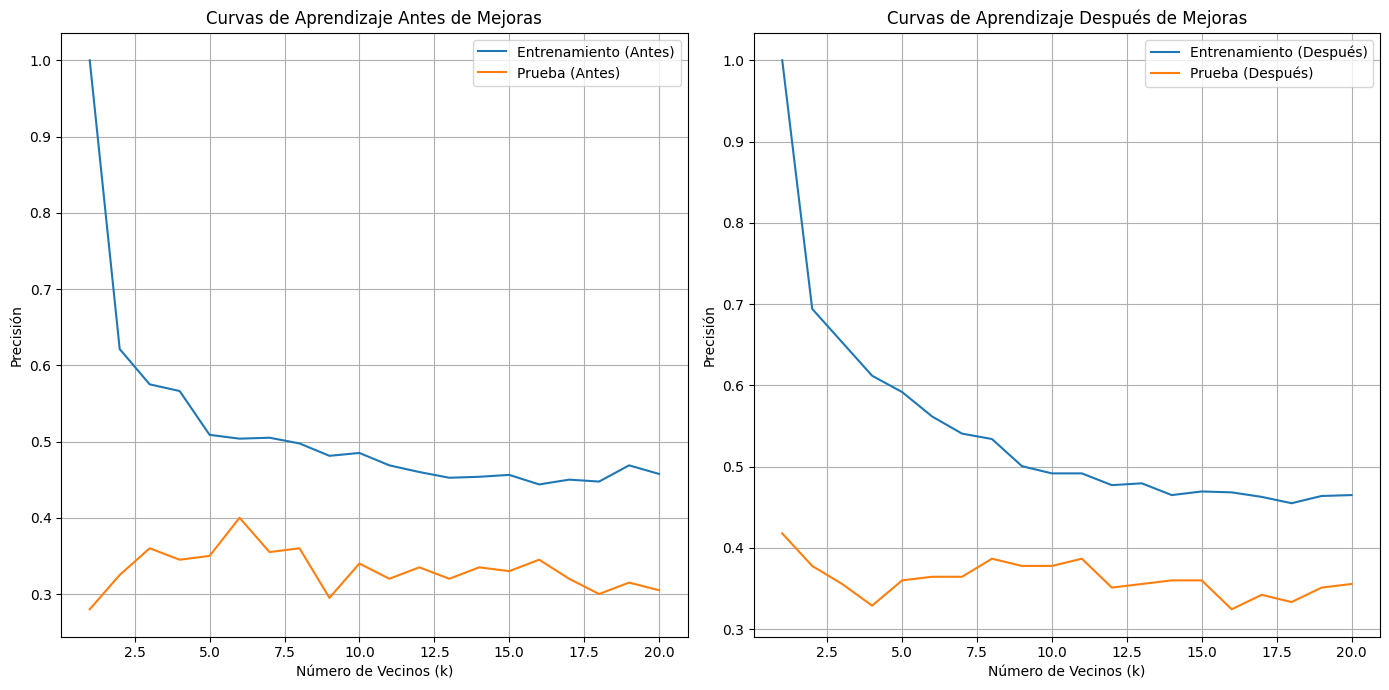

In [7]:
# Graficar resultados
plt.figure(figsize=(14, 7))

# Antes de mejoras
plt.subplot(1, 2, 1)
plt.plot(k_values, train_accuracies_raw, label="Entrenamiento (Antes)")
plt.plot(k_values, test_accuracies_raw, label="Prueba (Antes)")
plt.title("Curvas de Aprendizaje Antes de Mejoras")
plt.xlabel("Número de Vecinos (k)")
plt.ylabel("Precisión")
plt.legend()
plt.grid()

# Después de mejoras
plt.subplot(1, 2, 2)
plt.plot(k_values, train_accuracies_opt, label="Entrenamiento (Después)")
plt.plot(k_values, test_accuracies_opt, label="Prueba (Después)")
plt.title("Curvas de Aprendizaje Después de Mejoras")
plt.xlabel("Número de Vecinos (k)")
plt.ylabel("Precisión")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()


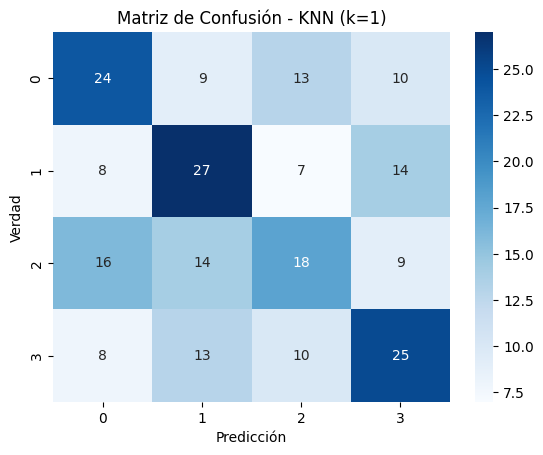

In [9]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title(f"Matriz de Confusión - KNN (k={optimal_k})")
plt.xlabel("Predicción")
plt.ylabel("Verdad")
plt.show()

In [8]:
# Guardar modelos
import joblib
joblib.dump(best_knn, 'model_knn_42_end.pkl')

['model_knn_42_end.pkl']